# "Segmentez des clients d'un site e-commerce"
_Cleaning Notebook_

## 0 Preliminaries

In [1]:
# !pip install flake8 pycodestyle_magic
# !pip install gtts
# !pip install category-encoders
# !pip install mlxtend==0.17.3 # makes Google Colab asking for reboot
# !pip install ppscore

In [2]:
# !pip freeze > requirements_cleaning_eda.txt

Checking for PEP8 compliance

In [3]:
# %load_ext pycodestyle_magic
# %pycodestyle_on
# %pycodestyle_off

### 0.0 Importing Packages and Modules

Checking whether the notebook is on Colab or PC

In [4]:
import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

Mounting my Drive if on colab

In [5]:
if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Mounted at /gdrive
/gdrive
You're on Google Colab


Installations and importations required in the virtual environment.

In [6]:
import os
if is_colab==True:
    if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS':
        os.chdir('My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS')
else:
    if not (os.path.exists(os.getcwd()+'/requirements_cleaning_eda.txt') \
                     and os.path.exists(os.getcwd()+'/P5_functions.py')):
        print("ERROR: Make sure 'P5_functions.py' and 'requirements_cleaning_eda.txt' are in the current working directory")

!pip install -r requirements_cleaning_eda.txt
from P5_functions import *

     |████████████████████████████████| 112kB 8.7MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 133kB 16.4MB/s 
     |████████████████████████████████| 6.5MB 11.7MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 7.8MB 47.1MB/s 
     |████████████████████████████████| 163kB 38.8MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 143kB 36.2MB/s 
     |████████████████████████████████| 81kB 9.7MB/s 
     |████████████████████████████████| 92kB 8.0MB/s 
     |████████████████████████████████| 3.4MB 55.8MB/s 
     |████████████████████████████████| 92kB 9.8MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 
     |████████████████████████████████| 1.3MB 46.3MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 1.6MB 57.8MB/s 
     |█████

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Importation of modules and packages. 

In [7]:
import io
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

Setting pandas display options

In [8]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
    pd.set_option(k,v)

To play audio text-to-speech during execution.

In [9]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

To check for existing pickles

In [10]:
import dill

def load_pickle(f_name):
# If file of models exists, open and load in dict_model
    if os.path.exists(f_name):
        with open(f_name, "rb") as f:
            d_file = dill.load(f)
        print('--Pickle already existing as ',
              f_name, ':\n', d_file.keys())
        print("Content loaded from '", f_name, "'.")
        return d_file
    # Else create an empty dictionary
    else:
        print('--No pickle yet as ',f_name)
        return {}

In [11]:
speak('Packages and modules successfully imported')

### 0.1 Importing the Aggregated Orders dataset

Let's load the dataframe of aggregated orders as well as the dataframe of aggregated customers.

This way, we'll be able to reconstruct the dataframe of customer on different slots of time later on.

In [12]:
if is_colab==True:
    # Importing database from my Drive
    print("Try to import data files in the notebook from myDrive...")
else:
    # Importing database from PC
    print("Try to import data files in the notebook from PC ('DATA')...")

df_cust = pd.read_csv('agg_customers.csv', sep=',', index_col='customer_unique_id',
                        encoding ='utf-8').drop(columns=['Unnamed: 0'])

df_orders = pd.read_csv('agg_orders.csv', sep=',', index_col='order_id',
                        encoding ='utf-8').drop(columns=['Unnamed: 0'])

print("-----> Importation of .csv in the notebook: OK")

Try to import data files in the notebook from myDrive...
-----> Importation of .csv in the notebook: OK


All the dates and timestamps in the dataframes are to be converted.

In [13]:
# Dates are converted in datetime format, and timedeltas in timedeltas
df_orders[['order_purchase_timestamp', 'max_limit_ship_date']] = \
    df_orders[['order_purchase_timestamp', 'max_limit_ship_date']]\
        .apply(lambda x: pd.to_datetime(x))
df_orders[['shipping_time', 'shipping_delay']] = \
    df_orders[['shipping_time', 'shipping_delay']]\
        .apply(lambda x: pd.to_timedelta(x))  
df_orders['cust_region'] = \
    df_orders['cust_region'].astype('object')

# Time in df_cust are already encoded in days (int)
df_cust['cust_region'] = \
    df_cust['cust_region'].astype('object')

In [14]:
df_orders.shape

(99441, 36)

In [15]:
df_orders.columns

Index(['customer_unique_id', 'cust_region', 'order_status', 'order_purchase_timestamp',
       'order_item_nb', 'product_volume_cm3', 'product_weight_g', 'mean_prod_descr_length',
       'shipping_time', 'shipping_delay', 'max_limit_ship_date', 'delivered', 'price',
       'freight_value', 'review_score', 'review_comment_length', 'payment_installments',
       'payment_value', 'paytype_boleto', 'paytype_credit_card', 'paytype_debit_card',
       'paytype_not_defined', 'paytype_voucher', 'cat_home', 'cat_furniture', 'cat_electronics',
       'cat_office', 'cat_diy', 'cat_food', 'cat_miscellaneous', 'cat_multimedia', 'cat_fashion',
       'cat_books', 'cat_hygiene', 'cat_unknown', 'cat_leisure'],
      dtype='object')

In [16]:
df_orders.dtypes.value_counts()

float64            28
object              3
datetime64[ns]      2
timedelta64[ns]     2
int64               1
dtype: int64

In [17]:
df_cust.dtypes.value_counts()

float64    34
int64       8
object      1
dtype: int64

In [18]:
speak('Dataset successfully imported')

## 1 Data preprocessing

### 1.1 Aggregation of the customers dataset on custom time slots 

If we need to recompute the dataset in another period of time, we just need to call the function below, indicating as argument the right t_min and t_max.

In [19]:
# Aggregation in a chosen time slot
# all customers (for max period of time): (96095, 22)

# t_min = pd.Timestamp('2017-10-17 17:30:18')
# t_max = pd.Timestamp('2018-01-01 17:30:18')

def generate_cust_df(df_orders, t_min=None, t_max=None):
    df_cust = create_agg_cust_df(df_orders, t_min=t_min, t_max=t_max)
    df_cust = create_features_cust_df(df_cust)
    return df_cust

# test_df_cust = generate_cust_df(df_orders, t_min=None, t_max=None)

In [20]:
# df_cust.columns

Here we use a custom transformer (see the class CustTransformer in P5_functions.py) to:
- encode categorical data with Ordinal Encoder
- Standardize the quantitative data with StandardScaler

In [21]:
# # Transformation and encoding
# ct = CustTransformer(strat_low_card='ohe',
#                      strat_quant='stand')
# ct.fit(df_cust)
# df_cust_trans = ct.transform(df_cust)

In [22]:
# df_cust_trans.columns

### 1.2 Features selection, features reduction

#### Variance Inflation Factor

We'll use the variance inflation factor (VIF) to find the colinear features in our transformed dataset.
NB: the VIF of a feature among a group of features can be defined as 1/(1-R²), where R² is the R² score of a simple regression of this features over all the others. If R² is high (and hence VIF), it means that the feature can be very well approximated using one or more of the other features, and thus is the source of colinearity.
In the "select_from_vif_" function, we eliminate the most highly correlated features and recalculate VIF of each feature. Usually, VIF should not exceed 5.

In [23]:
# select_from_vif_(df_cust_trans, thresh=0.5).columns

The columns exceeding a VIF of 5 are :
- low_card__cust_region_1', (the most frequent region)
- 'paytype_credit_card_tot_nb', (the most frequent payment)
- 'tot_comment_length', correlated with 'mean_comment_length'
- 'tot_nb_deliv_ord' and 'tot_nb_items', correlated resp. with 'tot_nb_ord' and - 'mean_nb_items_per_ord'
- 'mean_ship_delay', correlated with 'mean_ship_time'
- 'time_since_first_purch' correlated with 'time since_mast_purch'
- 'tot_price', 'tot_freight_val', 'tot_pay_value', mean_price_per_order', 'mean_pay_value_per_order', correlated with 'mean_nb_items_per_ord'

We decide to drop the foollowing columns:

In [24]:
col_vif_drop = ['time_since_first_purch', 'tot_comment_length',
                'tot_nb_deliv_ord', 'tot_nb_items', 'tot_pay_value',
                'paytype_credit_card_tot_nb', 'tot_freight_val',
                'mean_price_per_order', 'mean_pay_value_per_order',
                'mean_ship_delay']
df_cust_vif = df_cust.drop(columns=col_vif_drop)
df_cust_vif.shape

(96096, 33)

#### Low variance features

Checking for low variance features before transformation

In [25]:
# # Transformation and encoding
# ct = CustTransformer(strat_low_card='ohe', # One_Hot enc for categorical
#                      strat_quant='none') # no standardization
# df_enc = ct.fit_transform(df_cust_vif)

# thresholds = [0,0.02,0.05,0.1,5,20,100,200,300,1000,5000,10000,25000,50000]

# df_feat_var = check_feature_variance(thresholds, df_enc)

In [26]:
# plt.plot(df_feat_var['thresh']+0.0001, df_feat_var['n_rem_cols'],  '-or')

# ax = plt.gca()
# ax.set_xlabel('Variance threshold')
# ax.set_ylabel('Number of remaining columns')
# ax.set_xscale('log')
# # ax.set_yscale('log')

A lot of feature have low variance, but it is partially due to the scale of the data. Let's try several quantitative transformations to see if the variance of these data can be increased. 

In [27]:
# # Transformation and encoding
# ct1 = CustTransformer(strat_low_card='ohe', # One_Hot enc for categorical
#                      strat_quant='none') # no transformation
# df_enc = ct1.fit_transform(df_cust_vif)

# print("------STANDARDIZATION-------")
# ct2 = CustTransformer(strat_binary='ord',
#                       strat_low_card='none', 
#                       strat_quant='stand') # Standardization
# df_enc_trans_A = ct2.fit_transform(df_enc)
# th_A = np.arange(0,1.05,0.05)
# df_res_A = check_feature_variance(th_A, df_enc_trans_A)

# print("------QUANTILE NORMALISATION (norm)-------")
# ct2 = CustTransformer(strat_binary='ord',
#                       strat_low_card='none', 
#                       strat_quant='quant_norm') # Standardization
# df_enc_trans_B = ct2.fit_transform(df_enc)
# th_B = np.arange(0,1.05,0.05)
# df_res_B = check_feature_variance(th_B, df_enc_trans_B)

# print("------QUANTILE NORMALISATION (unif)-------")
# ct2 = CustTransformer(strat_binary='ord',
#                       strat_low_card='none', 
#                       strat_quant='quant_uni') # Standardization
# df_enc_trans_C = ct2.fit_transform(df_enc)
# th_C = np.arange(0,0.2,0.01)
# df_res_C = check_feature_variance(th_C, df_enc_trans_C)

In [28]:
# plt.plot(df_res_A['thresh']+0.0001, df_res_A['n_rem_cols'],
#          '-or', label='standardization', zorder=10)
# plt.plot(df_res_B['thresh']+0.0001, df_res_B['n_rem_cols'],
#          '-ob', label='quantile_trans(normal)', zorder=5)
# plt.plot(df_res_C['thresh']+0.0001, df_res_C['n_rem_cols'],
#          '-og', label='quantile_trans(uniform)', zorder=1)

# ax = plt.gca()
# ax.set_xlabel('Variance threshold')
# ax.set_ylabel('Number of remaining columns')
# # ax.set_xscale('log')
# ax.legend()
# # ax.set_yscale('log')
# plt.show()


Apart from 'mean_nb_items_per_ord' and 'single_purch, most of the low variance columns are, without surprise, dummy columns (region, payment type and category).
We will nevertheless keep the columns for the moment and try a feature selection.


#### PCA

In [29]:
# # Data selection
# sel_cols = [c for c in df_cust_vif.columns \
#             if not (('cat_' in c)\
#                     or ('paytype' in c)\
#                     or ('reg' in c))]
# print("Columns excluded :\n",
#       [c for c in df_cust_vif if c not in sel_cols])
# print("Columns included :\n", sel_cols)

# # Transformation and encoding
# ct1 = CustTransformer(strat_low_card='ohe',
#                       strat_quant='quant_norm')
# ct2 = CustTransformer(strat_quant='stand')
# df_sel_trans = ct2.fit_transform(ct1.fit_transform(df_cust_vif[sel_cols]))

In [30]:
# from sklearn.decomposition import PCA

# n_comp = len(df_sel_trans.columns)
# pca = PCA(n_components=n_comp).fit(df_sel_trans)

# # Performing pca
# pca_comp = pd.DataFrame(pca.components_,
#                         index=['PC'+str(i+1) for i in range(n_comp)],
#                         columns=sel_cols).T

# # Projection of the dataframe on all pca axes
# df_proj_PCA = pd.DataFrame(pca.transform(df_sel_trans),
#                            index=df_sel_trans.index,
#                            columns=['PC'+str(i) for i in range(n_comp)])

Plotting heat map of the principal components

In [31]:
# plot_heatmap(pca_comp,'Principal components coefficients',
#              vmin=-1, vmax=1, center=0,
#              palette=sns.color_palette("coolwarm", 20),
#              figsize=(10,6),shape='rect')
# plt.show()

Plotting explained variance ratio in scree plot

In [32]:
# exp_var_rat = pca.explained_variance_ratio_
# scree_plot(col_names= pca_comp.columns, exp_var_rat=exp_var_rat,
#            ylim=(0,0.6), figsize=(14,3))
# plt.grid()
# plt.show()

Without the dummy columns, 80% of the variance of the 15 columns is in the 8 first principal components.
With a quantile transformation (normal) before the standardization, more variance can be obtained on the first axes.

#### UMAP

In [33]:
# # Data selection
# sel_cols = [c for c in df_cust_vif.columns \
#             if not (('cat_' in c)\
#                     or ('paytype' in c)\
#                     or ('reg' in c))]
# print("Columns excluded :\n",
#       [c for c in df_cust_vif if c not in sel_cols])
# print("Columns included :\n", sel_cols)

# # Transformation and encoding
# ct1 = CustTransformer(strat_low_card='ohe',
#                       strat_quant='quant_norm')
# ct2 = CustTransformer(strat_quant='stand')
# df_sel_trans = ct2.fit_transform(ct1.fit_transform(df_cust_vif[sel_cols]))

In [34]:
# from umap import UMAP

# df = df_sel_trans

# n_comp = len(df.columns)

# # UMAP instantiation
# umap = UMAP(n_components=n_comp, n_neighbors=15, min_dist=0.1, init='spectral',
#             random_state=14)

# # Fitting the model, projecting data on UMAP axes
# df_proj_UMAP = pd.DataFrame(umap.fit_transform(df),
#                            index=df.index,
#                            columns=['UMAP'+str(i) for i in range(n_comp)])

### 1.3 Preparing data before clustering

Here we use a custom transformer (see the class CustTransformer in P5_functions.py) to:
- encode categorical data with Ordinal Encoder
- Standardize the quantitative data with StandardScaler

In [35]:
# Sampling
ind_samp_1000 = df_cust.sample(1000, random_state=14).index
ind_samp_5000 = df_cust.sample(5000, random_state=14).index
ind_samp_10000 = df_cust.sample(10000, random_state=14).index

In [36]:
vif_cols = [c for c in df_cust.columns if c not in df_cust_vif.columns]

In [37]:
cat_cols = [c for c in df_cust.columns if ('cat_' in c)]
reg_cols = [c for c in df_cust.columns if ('reg' in c)]
pay_cols = [c for c in df_cust.columns if ('paytype' in c)]+['mean_pay_install']

In [38]:
prod_spec_cols = ['mean_prod_vol_cm3', 'mean_prod_descr_length', 'mean_prod_wei_g',
             'avg_freight_payval_ratio', 'mean_ship_delay', 'mean_ship_time']
satisf_cols = ['mean_comment_length', 'tot_comment_length', 'mean_rev_score',
               'nb_not_rec_orders']
recency_cols = ['time_since_last_purch', 'time_since_first_purch']
monetary_cols = ['mean_freight_val_per_order', 'tot_freight_val',
                 'mean_price_per_order', 'tot_price',
                 'avg_freight_payval_ratio', 'mean_pay_value_per_order',
                 'tot_pay_value']
frequency_cols = ['tot_nb_deliv_ord', 'tot_nb_ord', 'single_purch',
                  'mean_nb_items_per_ord', 'tot_nb_items']  

In [39]:
all_cols = (list(set(cat_cols + reg_cols + pay_cols + vif_cols\
                     + prod_spec_cols + satisf_cols + recency_cols\
                     + monetary_cols + frequency_cols)))

In [40]:
len(df_cust.columns), len(all_cols),\
    [c for c in df_cust.columns if c not in all_cols]

(43, 43, [])

#### All the variables (df1_1)

In [41]:
# Data selection
df1_1 = df_cust[all_cols]
# Transformation and encoding
ct1 = CustTransformer(strat_low_card='ohe',
                      strat_quant='none')
df1_1 = ct1.fit_transform(df1_1)

# Transformation and encoding
ct2 = CustTransformer(strat_quant='quant_norm')

df1_1_trans = ct2.fit_transform(df1_1)

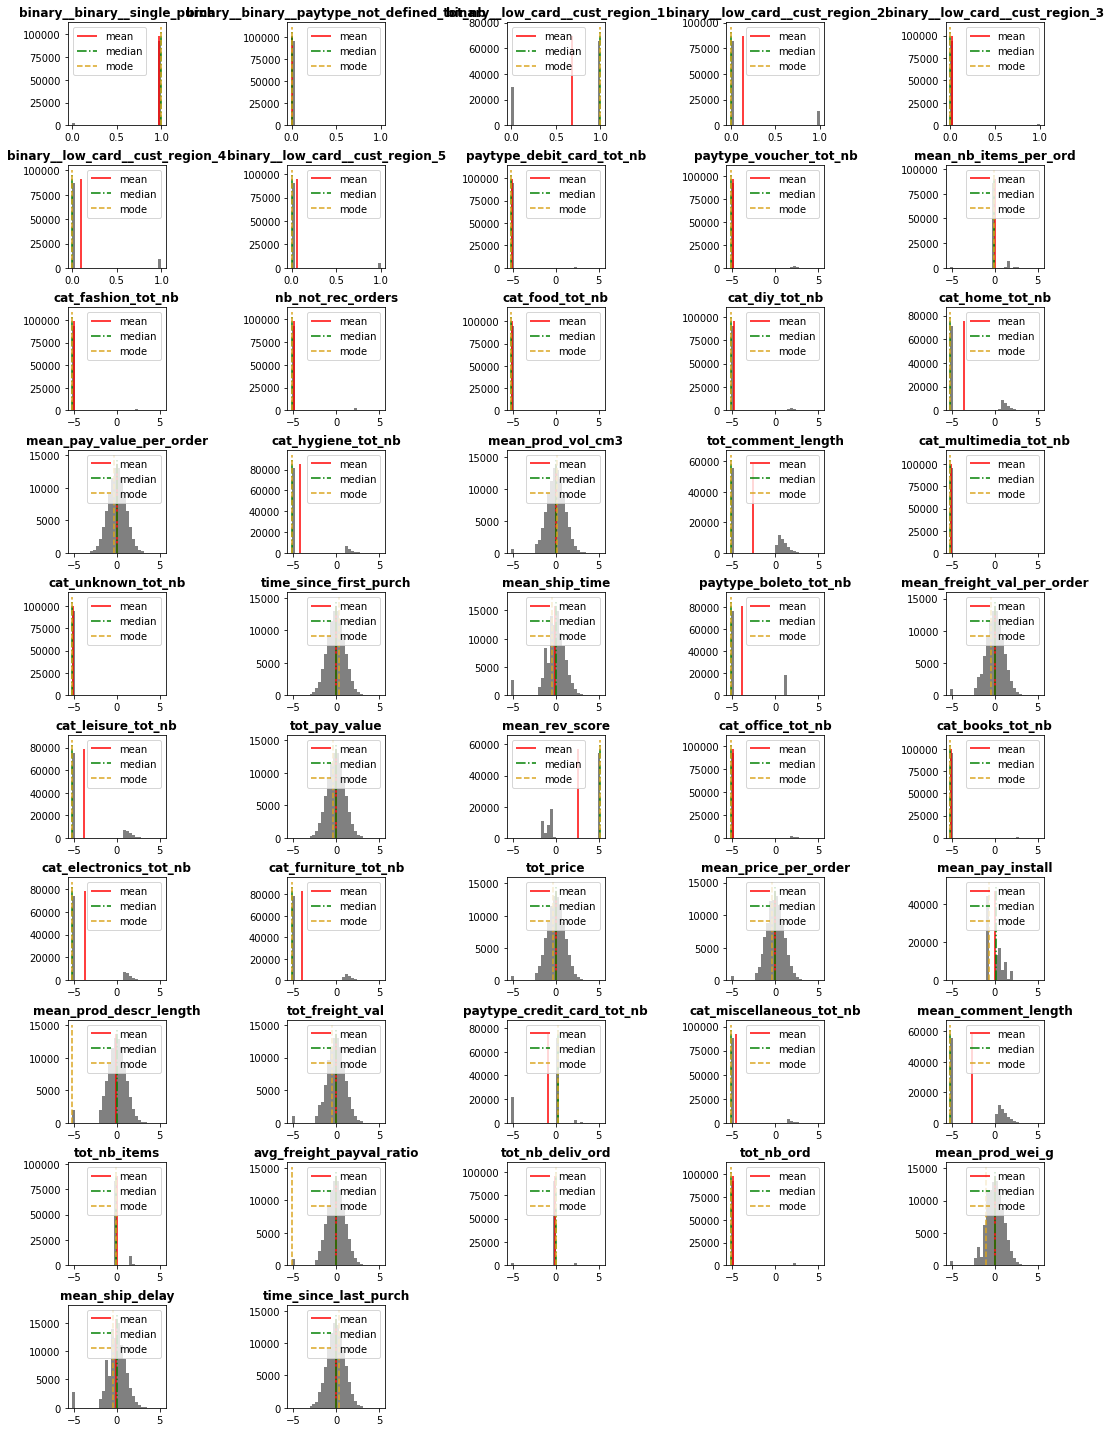

In [42]:
# Histograms of the transformed data
plot_histograms(df=df1_1_trans, cols=df1_1_trans.columns,
                figsize=(15,20), bins=30, layout=(10,5))

#### All the variable, UMAP 10 comp (df1_2)

In [43]:
# # Data selection
# df1_2 = df_cust[all_cols]

# # Transformation and encoding
# ct = CustTransformer(strat_low_card='ohe',
#                       strat_quant='none')
# df1_2 = ct.fit_transform(df1_2)

In [44]:
# from umap import UMAP

# n_comp = 10
# umap = UMAP(n_components=n_comp, n_neighbors=15, min_dist=0.1, init='spectral',
#             random_state=14)

# # Fitting the model, projecting data on UMAP axes
# df1_2_trans = pd.DataFrame(umap.fit_transform(df1_2),
#                             index=df1_2.index,
#                             columns=['UMAP'+str(i) for i in range(n_comp)])

In [45]:
# # Transformation and encoding
# ct = CustTransformer(strat_quant='quant_norm')

# df1_2_trans = ct.fit_transform(df1_2_trans)

In [46]:
# # Histograms of the transformed data
# plot_histograms(df=df1_2_trans, cols=df1_2_trans.columns,
#                 figsize=(12,8), bins=30, layout=(3,4))

#### All RFM features (df2_1)

In [47]:
# Data selection
sel_cols_2_1 = recency_cols\
            + frequency_cols\
            + monetary_cols

df2_1 = df_cust[sel_cols_2_1]

sel_cols_2_1

['time_since_last_purch',
 'time_since_first_purch',
 'tot_nb_deliv_ord',
 'tot_nb_ord',
 'single_purch',
 'mean_nb_items_per_ord',
 'tot_nb_items',
 'mean_freight_val_per_order',
 'tot_freight_val',
 'mean_price_per_order',
 'tot_price',
 'avg_freight_payval_ratio',
 'mean_pay_value_per_order',
 'tot_pay_value']

In [48]:
# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                     strat_quant='quant_norm')

df2_1_trans = ct.fit_transform(df2_1)

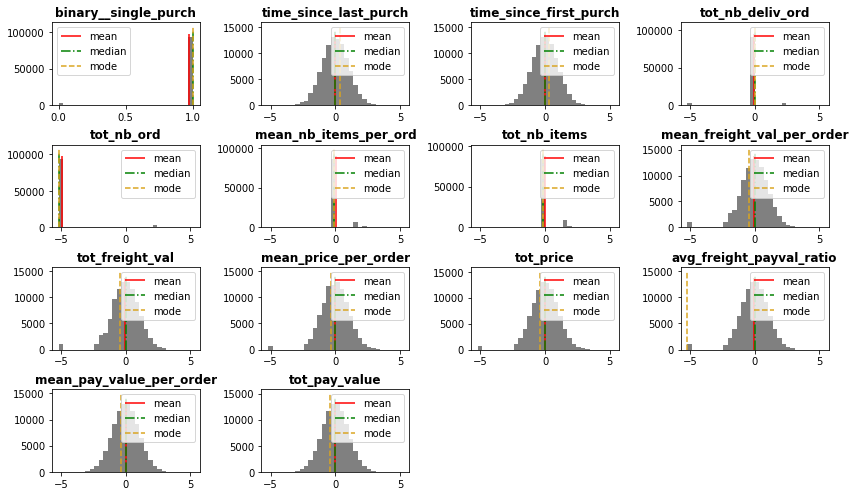

In [49]:
# Histograms of the transformed data
plot_histograms(df=df2_1_trans, cols=df2_1_trans.columns,
                figsize=(12,7), bins=30, layout=(4,4))

#### All RFM + paytype (df2_2)

In [50]:
# Data selection
sel_cols_2_2 = recency_cols\
            + frequency_cols\
            + pay_cols\
            + monetary_cols

df2_2 = df_cust[sel_cols_2_2]

sel_cols_2_2

['time_since_last_purch',
 'time_since_first_purch',
 'tot_nb_deliv_ord',
 'tot_nb_ord',
 'single_purch',
 'mean_nb_items_per_ord',
 'tot_nb_items',
 'paytype_not_defined_tot_nb',
 'paytype_boleto_tot_nb',
 'paytype_voucher_tot_nb',
 'paytype_debit_card_tot_nb',
 'paytype_credit_card_tot_nb',
 'mean_pay_install',
 'mean_freight_val_per_order',
 'tot_freight_val',
 'mean_price_per_order',
 'tot_price',
 'avg_freight_payval_ratio',
 'mean_pay_value_per_order',
 'tot_pay_value']

In [51]:
# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                      strat_quant='quant_norm')

df2_2_trans = ct.fit_transform(df2_2)

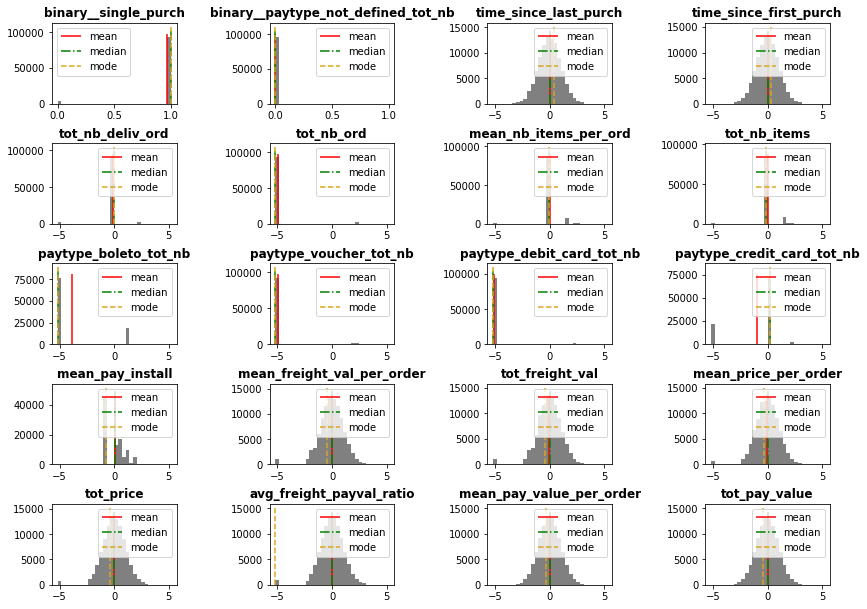

In [52]:
# Histograms of the transformed data
plot_histograms(df=df2_2_trans, cols=df2_2_trans.columns,
                figsize=(12,10), bins=30, layout=(6,4))

#### Selection RFM features (df2_3)

We want to a a first clustering based on the value, seniority and loyalty of a  customer. These qualities are defined by the typical RFM analysis (Recency, Frequency, Monetary). In our database, we can use the following features:
- Recency: 'time_since_first_purch'
- Monetary: 'tot_price'
- Frequency: 'tot_nb_ord', 'single_purch', 'time_since_last_purch'

NB: We know that the 'Frequency' will be the more difficult to apprehend, since the great majority of the customers had only one order, that's why we keep the three features as they are.

In [53]:
# Data selection
sel_cols_2_3 = ['tot_nb_ord', 'tot_price',
                'time_since_last_purch', 'time_since_first_purch']

df2_3 = df_cust[sel_cols_2_3]

In [54]:
# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                      strat_quant='quant_norm')

df2_3_trans = ct.fit_transform(df2_3)

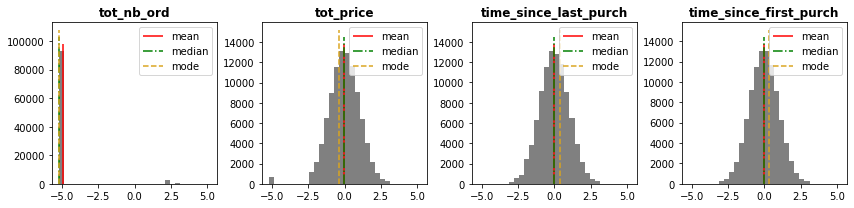

In [55]:
# Histograms of the transformed data
plot_histograms(df=df2_3_trans, cols=df2_3_trans.columns,
                figsize=(12,3), bins=30, layout=(1,4))

#### Product spec, review and monetary (df3_1)

In [56]:
# Data selection
sel_cols_3_1 = list(set(prod_spec_cols\
                + satisf_cols\
                + monetary_cols))

df3_1 = df_cust[sel_cols_3_1]

sel_cols_3_1

['mean_prod_vol_cm3',
 'mean_prod_descr_length',
 'tot_freight_val',
 'mean_price_per_order',
 'tot_comment_length',
 'tot_pay_value',
 'mean_comment_length',
 'nb_not_rec_orders',
 'avg_freight_payval_ratio',
 'mean_rev_score',
 'mean_ship_time',
 'mean_pay_value_per_order',
 'mean_prod_wei_g',
 'tot_price',
 'mean_ship_delay',
 'mean_freight_val_per_order']

In [57]:
# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                      strat_quant='quant_norm')

df3_1_trans = ct.fit_transform(df3_1)

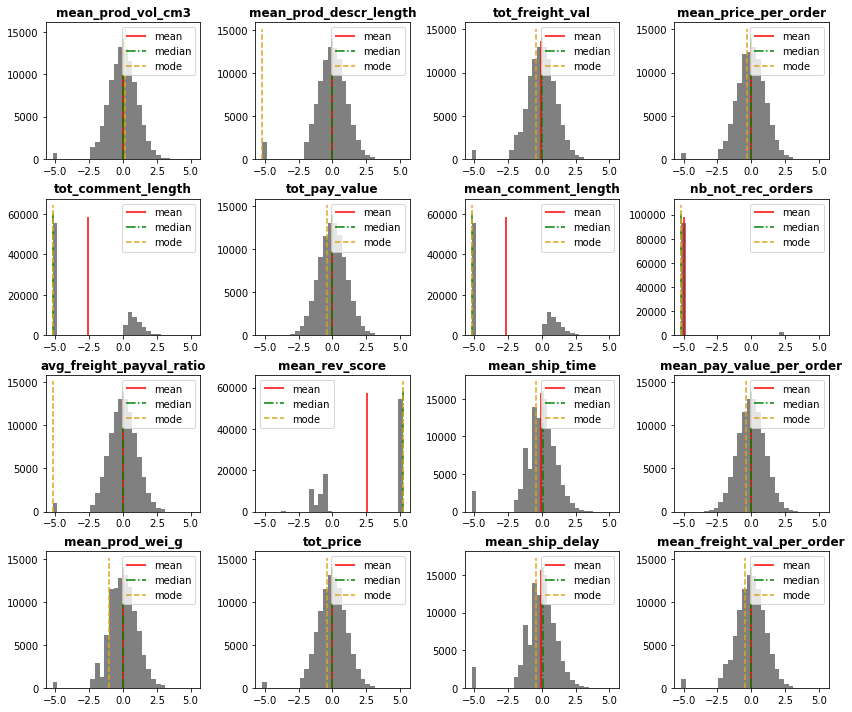

In [58]:
# Histograms of the transformed data
plot_histograms(df=df3_1_trans, cols=df3_1_trans.columns,
                figsize=(12,10), bins=30, layout=(4,4))

#### Product spec, satisfaction and monetary + category (df3_2)

In [59]:
# Data selection
sel_cols_3_2 = list(set(prod_spec_cols\
                + cat_cols\
                + satisf_cols\
                + monetary_cols))

df3_2 = df_cust[sel_cols_3_2]

sel_cols_3_2

['cat_fashion_tot_nb',
 'nb_not_rec_orders',
 'cat_food_tot_nb',
 'cat_diy_tot_nb',
 'cat_home_tot_nb',
 'mean_pay_value_per_order',
 'cat_hygiene_tot_nb',
 'mean_prod_vol_cm3',
 'tot_comment_length',
 'cat_multimedia_tot_nb',
 'cat_unknown_tot_nb',
 'mean_ship_time',
 'mean_freight_val_per_order',
 'cat_leisure_tot_nb',
 'tot_pay_value',
 'mean_rev_score',
 'cat_office_tot_nb',
 'cat_books_tot_nb',
 'cat_electronics_tot_nb',
 'cat_furniture_tot_nb',
 'tot_price',
 'mean_price_per_order',
 'mean_prod_descr_length',
 'tot_freight_val',
 'cat_miscellaneous_tot_nb',
 'mean_comment_length',
 'avg_freight_payval_ratio',
 'mean_prod_wei_g',
 'mean_ship_delay']

In [60]:
# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                      strat_quant='quant_norm')

df3_2_trans = ct.fit_transform(df3_2)

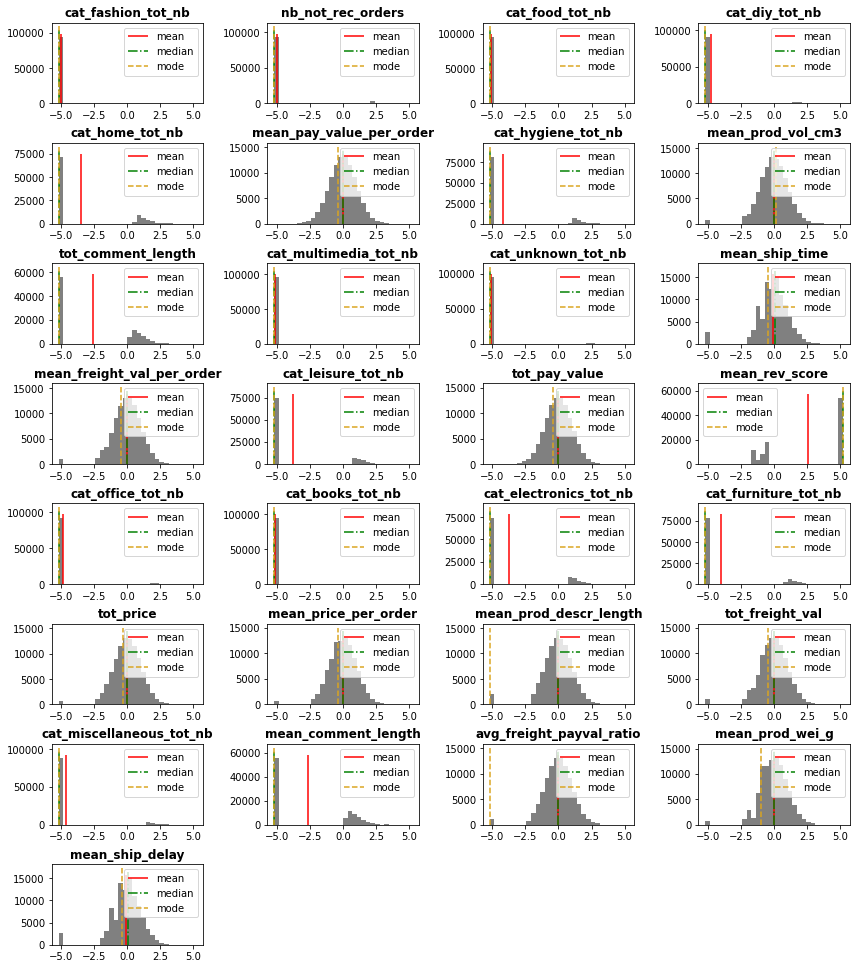

In [61]:
# Histograms of the transformed data
plot_histograms(df=df3_2_trans, cols=df3_2_trans.columns,
                figsize=(12,15), bins=30, layout=(9,4))

#### Selection Product spec, review and monetary (df3_3)


In [62]:
# Data selection
sel_cols_3_3 = ['mean_pay_value_per_order', 'avg_freight_payval_ratio', 
                'nb_not_rec_orders', 'mean_prod_wei_g', 'mean_comment_length', 
                'mean_rev_score', 'mean_prod_vol_cm3', 'mean_prod_descr_length',
                'tot_price', 'tot_comment_length', 'mean_ship_delay']

df3_3 = df_cust[sel_cols_3_3]

In [63]:
# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                      strat_quant='quant_norm')

df3_3_trans = ct.fit_transform(df3_3)

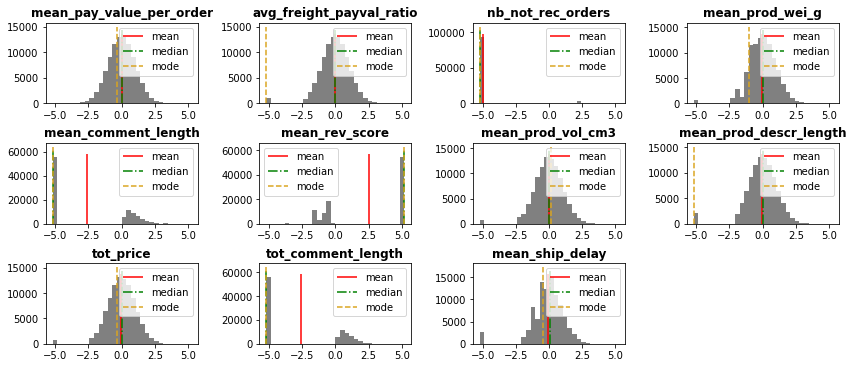

In [64]:
# Histograms of the transformed data
plot_histograms(df=df3_3_trans, cols=df3_3_trans.columns,
                figsize=(12,15), bins=30, layout=(9,4))

#### SELECTION A

**Product related features**: 'mean_prod_descr_length', 'mean_prod_wei_g'

**Shipping Related features**: 'avg_freight_payval_ratio', 'mean_ship_time'

**Satisfaction related features**: 'tot_comment_length', 'mean_rev_score',

**RFM related features** (Recency, Frequency, Monetary): 'time_since_last_purch', 'tot_price', 'tot_nb_ord', 'mean_nb_items_per_ord'

In [65]:
# Data selection
sel_cols_A = ['mean_prod_descr_length', 'mean_prod_wei_g',
              'avg_freight_payval_ratio','mean_ship_time',
              'tot_comment_length', 'mean_rev_score', 'time_since_last_purch',
              'tot_price', 'tot_pay_value', 'tot_nb_ord',
              'mean_nb_items_per_ord']

dfA = df_cust[sel_cols_A]

In [66]:
# Transformation and encoding
ct = CustTransformer(strat_quant='quant_norm')

dfA_trans = ct.fit_transform(dfA)

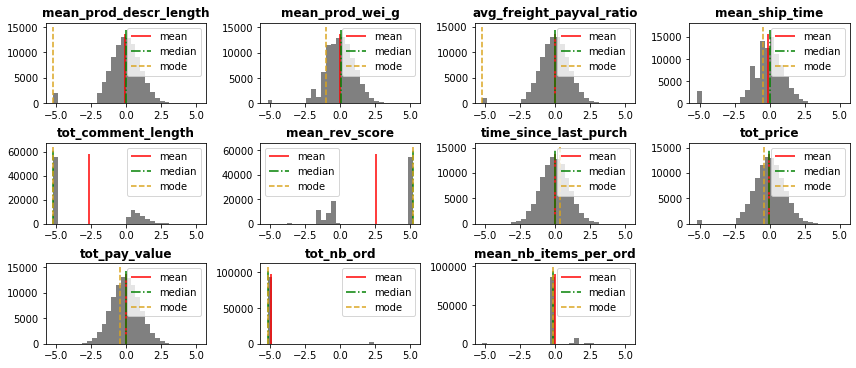

In [67]:
# Histograms of the transformed data
plot_histograms(df=dfA_trans, cols=dfA_trans.columns,
                figsize=(12,15), bins=30, layout=(9,4))

#### SELECTION B

In [68]:
prod_spec_cols = ['mean_prod_vol_cm3', 'mean_prod_descr_length', 'mean_prod_wei_g',
             'avg_freight_payval_ratio', 'mean_ship_delay', 'mean_ship_time']
satisf_cols = ['mean_comment_length', 'tot_comment_length', 'mean_rev_score',
               'nb_not_rec_orders']
recency_cols = ['time_since_last_purch', 'time_since_first_purch']
monetary_cols = ['mean_freight_val_per_order', 'tot_freight_val',
                 'mean_price_per_order', 'tot_price',
                 'avg_freight_payval_ratio', 'mean_pay_value_per_order',
                 'tot_pay_value']
frequency_cols = ['tot_nb_deliv_ord', 'tot_nb_ord', 'single_purch',
                  'mean_nb_items_per_ord', 'tot_nb_items']  

## 2 KMeans clustering

In [71]:
from sklearn.cluster import KMeans

In [79]:
my_cols = ['mean_prod_descr_length', 'mean_prod_wei_g',
           'avg_freight_payval_ratio', 'mean_ship_time',
           'time_since_last_purch', 'tot_price','tot_pay_value']

In [140]:
df = dfA_trans.loc[:, my_cols]   #.loc[ind_samp_10000]
df_expl = dfA.loc[:, my_cols]

### 2.0 Evaluation of sampling relevancy

Calculations on the whole database can take a lot of time.
We would like to take only a sample of the dataset, but we need to check:
- if a model fitted on a sample give the same clusters as one fitted onthe whole dataset
- if so, whether this is reproducible for any sample (independent of the choice)

To check this we will:
- train at first one model on the whole dataset ("whole model")
- train models with limited number of samples ("samples models") from 100 to 50000
- predict cluster labels of the whole dataset with each of these models
- compute the ARI score of the "whole model" predictions vs. "sample models" 

In [145]:
# Choosing a model

km = KMeans(n_clusters=3)
km.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [285]:
# Clustering labels obtained by fitting with the whole dataset

ser_clust_all = pd.Series(km.predict(df),
                          index=df.index,
                          name='all')

In [286]:
n_iter = 20
df_ARI_all_vs_sample_iter = pd.DataFrame()

# Looping over a number of iteration
for i in range(n_iter):

    # print(f"ooo ITERATION {i} ooo")

    # Defining a list of sample indexes (random_state changes)
    li_n_samp = [100, 250, 500, 750, 1000, 2000, 3000,
                4000, 5000, 7500, 10000, 20000, 50000]
    list_samp_ind = [df_cust.sample(i).index for i in li_n_samp]

    # Clustering labels obtained by fitting with samples
    df_ARI_sampl = pd.DataFrame(ser_clust_all.to_frame())
    for ind_samp in list_samp_ind:
        n_samp = len(ind_samp)
        # print("ooooooooo Number of samples: ", n_samp)
        km.fit(df.loc[ind_samp])
        ser_clust = pd.Series(km.predict(df),
                              index=df.index,
                              name=str(n_samp)+'_sampl').to_frame()
        df_ARI_sampl = pd.concat([df_ARI_sampl, ser_clust], axis=1)

    # Computing the ARI score (whole dataset) between predictions with 
    # the "all" model vs predictions with "sample" model
    stab_sampl_kmeans = ARI_column_pairs(df_ARI_sampl, first_vs_others=True,
                                         print_opt=False)
    df_ARI_all_vs_sample_iter = pd.concat([df_ARI_all_vs_sample_iter,
                                        stab_sampl_kmeans.to_frame()],
                                        axis=1)

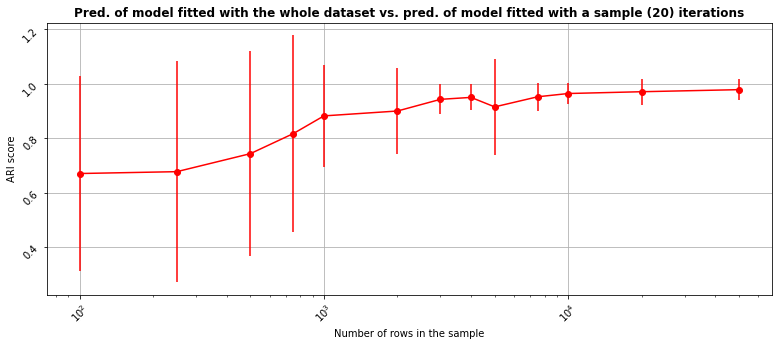

In [287]:
# Plotting the results

fig, ax = plt.subplots(1)
fig.set_size_inches(13,5)

ax.errorbar(li_n_samp,
             df_ARI_all_vs_sample_iter.mean(1).values,
             yerr=2*(df_ARI_all_vs_sample_iter.std(1).values),
             marker='o', color='red')

ax.tick_params(rotation=45)
ax.set_xscale('log')
plt.xlabel("Number of rows in the sample")
plt.ylabel("ARI score")
plt.title(f"Pred. of model fitted with the whole dataset \
vs. pred. of model fitted with a sample ({n_iter}) iterations", fontweight='bold')
plt.grid()
plt.show()

In [288]:
df_ARI_all_vs_sample_iter.mean(1)

[all, 100_sampl]     0.67
[all, 250_sampl]     0.68
[all, 500_sampl]     0.74
[all, 750_sampl]     0.82
[all, 1000_sampl]    0.88
[all, 2000_sampl]    0.90
[all, 3000_sampl]    0.94
[all, 4000_sampl]    0.95
[all, 5000_sampl]    0.92
[all, 7500_sampl]    0.95
[all, 10000_sampl]   0.96
[all, 20000_sampl]   0.97
[all, 50000_sampl]   0.98
dtype: float64

We can consider that a model fitted on a sample of 3000 give similar results as a model fitted on the whole dataset (ARI greater than 0.9)

### 2.1 Optimisation of the number of clusters

#### Evaluation of the KMeans clustering scores

We'll try to find the best number of cluster against:

- **Silhouette score**: measures the difference between the intra-cluster and nearest-cluster mean square distances (to maximize)
- **Davies_Bouldin score**: measures the maximal ratio of dispersion of pairs of clusters to their distance (to minimize)
- **Calinski_Harabasz score**: the ratio of inter-cluster dispersion to intra-cluster dispersion (to maximize)
- **Distortion**: the mean sum of squared distances to centers (find an elbow)

NB: the error bar represents 2 times the standard deviation (+/- 2 sigma)

In [82]:
# loading the pickled dataframes if already existing
# or create an empty dictionnary

dict_pkl = load_pickle("P5_dict_n_clust.pkl")

if dict_pkl != {}:
    dict_scores_iter = dict_pkl['scores']
    dict_ser_clust_n_clust = dict_pkl['ser_clust']
    dict_pop_perc_n_clust = dict_pkl['pop_clust']

--No pickle yet as  P5_dict_n_clust.pkl


In [89]:
%%time

# If the results are not existing (pickle) then recomputes
# Returns:
# - the aggregated results (mean, median, std) of the 4 scores
# - the list of the clusters predicted for each iteration and number of clusters
# - the proportion (pct) of the clusters 

if dict_pkl == {}:

    list_n_clust = range(2,8)
    n_iter = 10

    dict_scores_iter, dict_ser_clust_n_clust, dict_pop_perc_n_clust = \
                        compute_clust_scores_nclust(df,
                                                    list_n_clust=list_n_clust,
                                                    n_iter=n_iter,
                                                    return_pop=True)

CPU times: user 5.79 s, sys: 15.1 s, total: 20.9 s
Wall time: 7.46 s


In [369]:
import dill

# Storing the dictionaries in a pickle

dict_pkl = {'scores': dict_scores_iter,
            'ser_clust': dict_ser_clust_n_clust,
            'pop_clust':dict_pop_perc_n_clust}

with open("P5_dict_n_clust.pkl", "wb") as f:
    dill.dump(dict_pkl, f)
print("-----...dictionnaries dumped")

-----...dictionnaries dumped


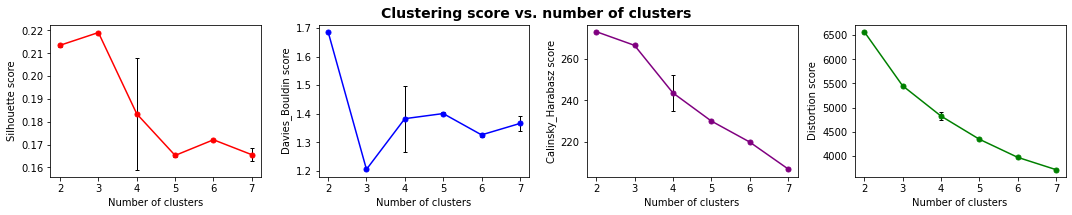

In [90]:
plot_scores_vs_n_clust(dict_scores_iter, figsize=(15,3))

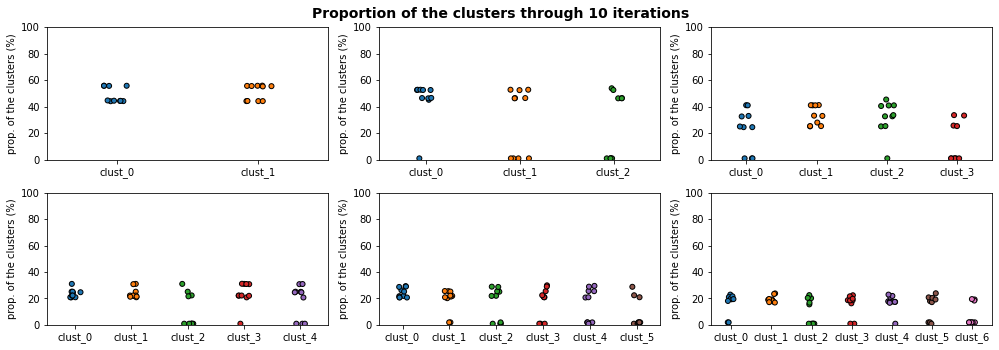

In [97]:
plot_prop_clust_vs_nclust(dict_pop_perc_n_clust, figsize=(14,7))

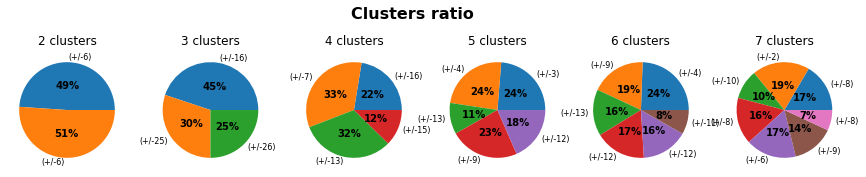

In [98]:
plot_clust_prop_pie_vs_nclust(dict_pop_perc_n_clust, list_n_clust, figsize=(15, 3))

#### Silhouette scores of each cluster

Let's now see in more details the silhouette scores of each cluster, for the different number of clusters.

On the left part of the graph, the silhouette coefficient is plotted for each number of clusters:
- the length of the bands is proportionnal to the size of the cluster
- the width of the small bars are the distance of each point to the closest centroid

On the right a representation of the clusters on UMAP projection of the data.

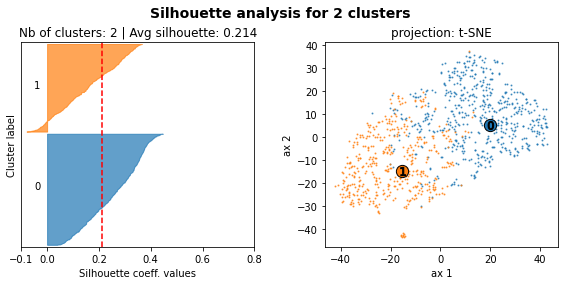

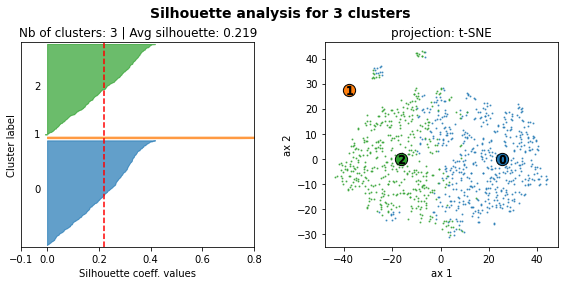

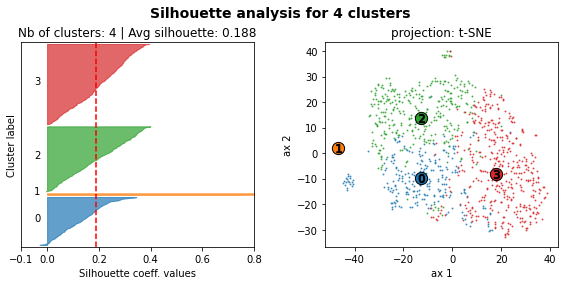

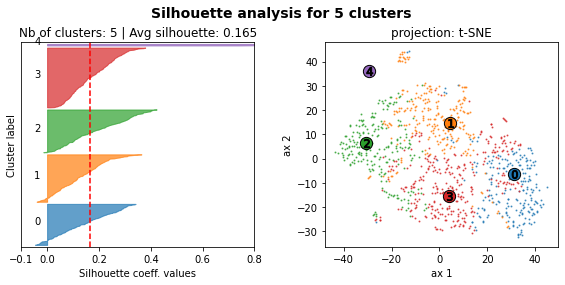

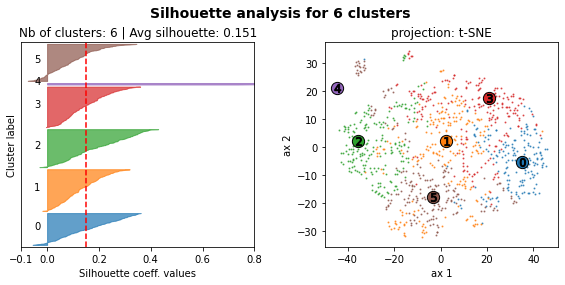

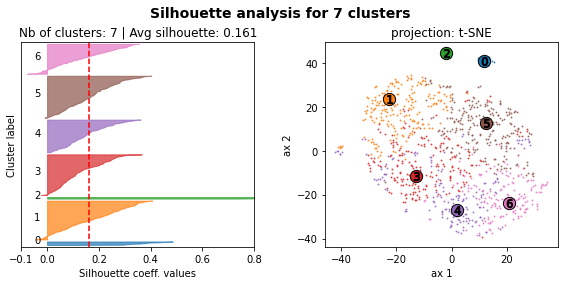

CPU times: user 2min 16s, sys: 2.2 s, total: 2min 18s
Wall time: 35 s


In [102]:
%%time

silh_scores_vs_n_clust(df, n_clust=list_n_clust, proj='t-SNE',
                       xlim=(-0.1,0.8), figsize=(8,4),
                       palette='tab10')

#### Checking for initialisation stability of the clusters

In [168]:
df_ARI_stab = pd.DataFrame()
for i in list_n_clust:
    print("ooooooooo Number of clusters: ", i)
    stab_init_kmeans = ARI_column_pairs(dict_ser_clust_n_clust[i])
    df_ARI_stab = pd.concat([df_ARI_stab, stab_init_kmeans.to_frame()], axis=1)

ooooooooo Number of clusters:  2
--- ARI all 45 unique pairs ---
Evaluation of stability with random init :
            ARI: mean=0.992, std=0.006, min=0.976, max=1.000 
ooooooooo Number of clusters:  3
--- ARI all 45 unique pairs ---
Evaluation of stability with random init :
            ARI: mean=0.981, std=0.020, min=0.945, max=1.000 
ooooooooo Number of clusters:  4
--- ARI all 45 unique pairs ---
Evaluation of stability with random init :
            ARI: mean=0.832, std=0.285, min=0.257, max=1.000 
ooooooooo Number of clusters:  5
--- ARI all 45 unique pairs ---
Evaluation of stability with random init :
            ARI: mean=0.982, std=0.011, min=0.965, max=1.000 
ooooooooo Number of clusters:  6
--- ARI all 45 unique pairs ---
Evaluation of stability with random init :
            ARI: mean=0.933, std=0.049, min=0.805, max=1.000 
ooooooooo Number of clusters:  7
--- ARI all 45 unique pairs ---
Evaluation of stability with random init :
            ARI: mean=0.747, std=0.095, mi

In [171]:
df_ARI_stab.head()

,ARI_2_clust_all_pairs,ARI_3_clust_all_pairs,ARI_4_clust_all_pairs,ARI_5_clust_all_pairs,ARI_6_clust_all_pairs,ARI_7_clust_all_pairs
"[iter_0, iter_1]",1.00,1.00,0.26,0.97,0.98,0.65
"[iter_0, iter_2]",1.00,0.95,0.99,0.99,0.98,0.71
"[iter_1, iter_2]",1.00,0.95,0.26,0.97,0.98,0.68
"[iter_0, iter_3]",1.00,0.99,0.98,1.00,0.87,0.75
"[iter_1, iter_3]",1.00,0.99,0.26,0.97,0.86,0.72


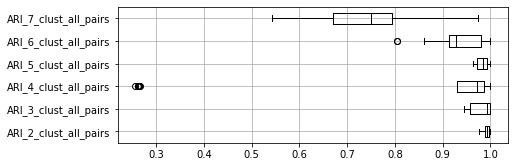

In [169]:
df_ARI_stab.boxplot(color='k', vert=False)
plt.gcf().set_size_inches(7,2.5)

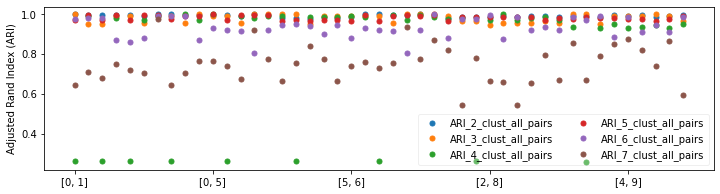

In [137]:
fig, ax = plt.subplots(1)
df_ARI_stab.plot(marker='o', markersize=5, linestyle='', ax=ax)
fig.set_size_inches(12,3)
ax.legend(ncol=2).get_frame().set_alpha(0.3)
ax.set_ylabel('Adjusted Rand Index (ARI)')
plt.show()

#### Visualisation of the best clusters

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# fit the model on the whole dataframe

n=5
best_model = KMeans(n_clusters=n, n_jobs=-1)
best_model.fit(df)
ser_clust = pd.Series(data=best_model.labels_,
                      index=df.index)

silh = silhouette_score(X=df, labels=ser_clust)
dav_bould = davies_bouldin_score(X=df, labels=ser_clust)
cal_harab = calinski_harabasz_score(X=df, labels=ser_clust)
distor = km.inertia_
silh, cal_harab, dav_bould, distor

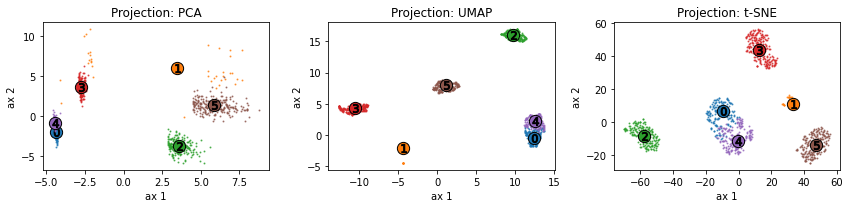

In [311]:
fig = plt.figure(figsize=(12,3))

tab_proj = ['PCA', 'UMAP', 't-SNE']
for i, proj in enumerate(tab_proj,1):
    ax = fig.add_subplot(1,len(tab_proj), i)
    # plot only a sample, but using the model already fitted
    plot_projection(df.sample(1000), model=best_model, proj=proj,
                    fig=fig, ax=ax)
fig.tight_layout()

### 2.2 Clusters analysis

We'll analyse the composition of the clusters given by the best model aboce fitted.

#### Contingency table, Chi square scores (clusters vs. binarized features)

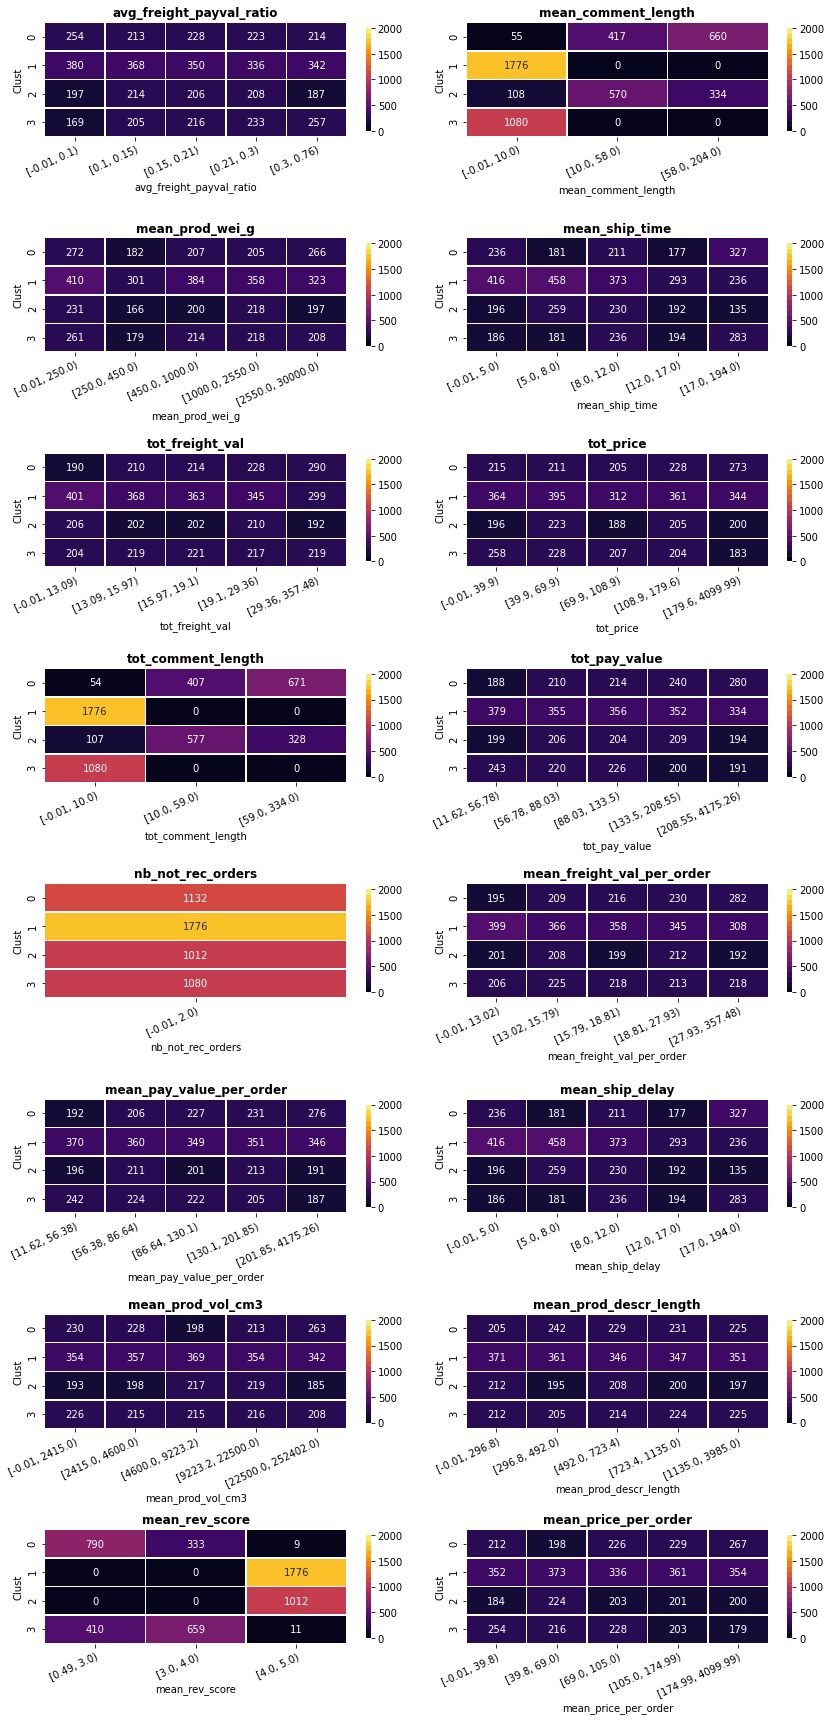

In [ ]:
contingency_tables(best_model, df, df_expl, palette="inferno",
                   cut_mode='quantile')

#### Relative difference of the mean

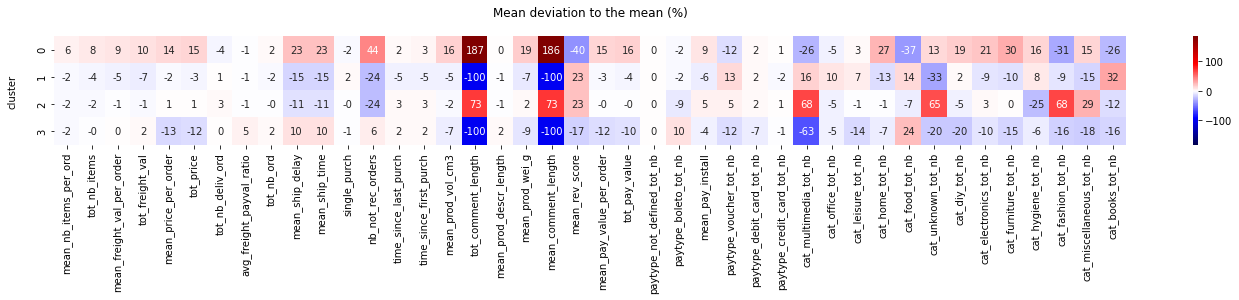

In [ ]:
clust_mean, orig_df_mean, rel_var = mean_deviation_clust(model, df,
                                                         df_cust.loc[df.index],
                                                         palette='seismic',
                                                         figsize=(24,2))

#### Snake plots

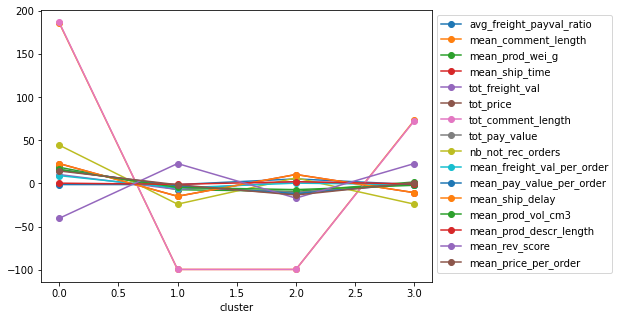

In [ ]:
# Plot the Snake plot

fig, ax = plt.subplots(1)
rel_var[df.columns].plot(marker='o', ax=ax)
ax.legend(ncol=1, bbox_to_anchor=[1,1])
fig.set_size_inches(7,5)
plt.show()

#### ANOVA and Kruskal-Wallis test with quantitative data

Let's see if the quantitative columns are significant features of the clustering.

At first we'll plot the distribution of the quantitative features for each cluster as boxplots.

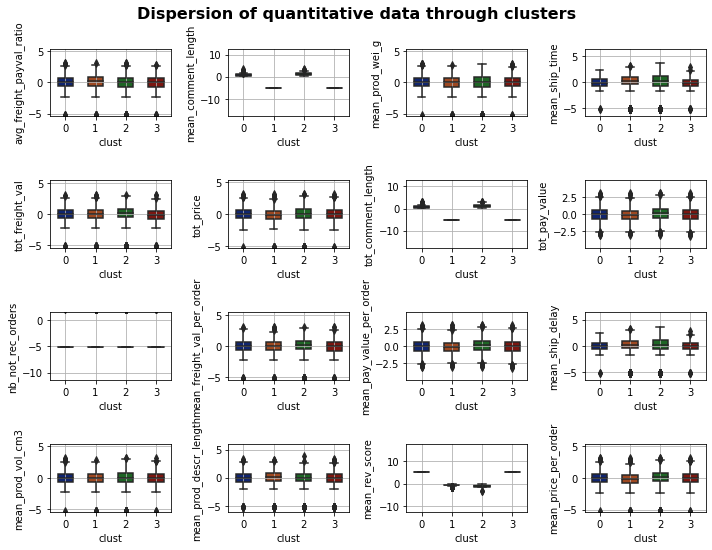

In [ ]:
## A METTRE SOUS FORME DE FONCTION ??
# Plotting boxplot of quantitative features for each cluster

model


fig = plt.figure(figsize=(10,8))

model = model.fit(df) if not is_fitted(model) else model
ser_clust = pd.Series(model.labels_,
                    index=df.index,
                    name='Clust')

with sns.color_palette('dark'):
    for i, c in enumerate(df.columns,1):
        ax = fig.add_subplot(4,4,i)
        sns.boxplot(data=df.assign(clust=ser_clust),
                    x='clust', y=c, width=0.5, ax=ax)
        min = df[c].mean()-5*df[c].std()
        max = df[c].mean()+5*df[c].std()
        plt.ylim(min,max)
        plt.grid()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Dispersion of quantitative data through clusters',
             fontsize=16, fontweight='bold')
plt.show()

Then we'll see if the features are significantly different between the clusters.

In [ ]:
# ANOVA and Kruskal-Wallis for each features against clusters

for i, col in enumerate(df.columns,1):
    test_distrib_clust(df.assign(clust=ser_clust), col,
                       'clust', print_opt=True);

In [ ]:
# Testing each category for one chosen test

def mult_test(data_df, test_func, print_opt=True, res_df=pd.DataFrame(), **kwargs):

    res_df_mod = res_df.copy('deep')

    for c in data_df.select_dtypes(include=np.number).columns:
        if print_opt: print('oooo--'+c+'--oooo')
        if test_func=='stat':
            dic_stat = stationary_tests(data_df[c], print_opt=print_opt)
        elif test_func=='id_dist':
            dic_stat = id_cat_distrib_tests(data_df, C_col=kwargs['C_col'],
                                            Q_col=c, print_opt=print_opt)
        else:
            print('ERROR: this function does not exist')
        for s in dic_stat.keys():
            res_df_mod.loc[s,c] = str(dic_stat.get(s))

    return res_df_mod

In [ ]:
# Results (p-value, same distr or not) of ANOVA and Kruskal-Wallis tests
# for 'nutriscore' vs. 'pnns1' categories

id_distr_pnns1 = mult_test(df[quant_cols+['pnns1']], C_col='pnns1',
                           test_func='id_dist', print_opt=False)
id_distr_pnns1

#### Diagrammes en Radar

In [ ]:
ser_clust = model.labels_
df_clust = df.assign(clust=ser_clust)
df_clust_mean = df_clust.groupby('clust').mean()
features_names = list(df.columns)
n_vars = len(features_names)

 model.labels_
clust_mean, orig_df_mean, rel_var

In [ ]:

# df : database transformée

model = model.fit(df) if not is_fitted(model) else model
ser_clust = pd.Series(model.labels_,
                    index=df.index,
                    name='Clust')

In [ ]:
# def radar_plot(df, ser_clust, cluster_index):

# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# Set data
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider( row, title, color):
 
    categories=list(df)[1:]
    N = len(categories)
    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] # "complete the loop"
    
    ax = plt.subplot(1,4,row+1, polar=True, )
    
    # First axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    
    ax.set_rlabel_position(0)
    plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
    plt.ylim(0,40)
    
    values=df.loc[row].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    
    plt.title(title, size=11, color=color, y=1.1)
    
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))
   
# Loop to plot
for row in range(0, len(df.index)):
    make_spider( row=row, title='group '+df['group'][row], color=my_palette(row))
plt.tight_layout()

#### Arbre de décision

Nous allons aussi utiliser un modèle supervisé afin de voir si nous pouvons prédire correctement les clusters construits avec k-means. Nous allons construire le modèle arbre de décision afin de voir:

Quels sont les features les plus importantes pour la construction de l'arbre
Avec quelle précision le modèle prédit les clusters sur les données test

Etant donné que les arbres de décision fonctionnent bien sur les données qui ne sont pas standardisées, nous allons utiliser le jeu de données avant la standardisation : data_analyses


In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    data_analyses, y_pred, test_size=0.3, random_state=1)

In [ ]:
arbre = DecisionTreeClassifier(max_depth=6, random_state=3)
arbre = arbre.fit(X_train, y_train)

In [ ]:
feature_importances = DataFrame(arbre.feature_importances_, index = data_analyses.columns)
feature_importances.rename({0:'Feature importance'}, axis=1, inplace=True)
feature_importances.sort_values(['Feature importance'], ascending=False, inplace=True)
feature_importances

In [ ]:
fig = plt.figure(figsize=(15, 8))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_ylabel('Feature importance', fontsize=15)
ax.set_title('Importance de 15 premiers features', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# set height of bar
bars1 = feature_importances['Feature importance'][:15]

# Make the plot
plt.bar(range(15), bars1, color='blue', edgecolor='white')

# Add xticks on the middle of the group bars
plt.xticks(
    range(15), feature_importances.index[:15],  rotation=90, fontsize=15)

# Show graphic
plt.show()

### 2.3 Clusters stability over time

#### Databases generation over increasing slots of time

In [ ]:
t_first = df_orders['order_purchase_timestamp'].min()
t_last = df_orders['order_purchase_timestamp'].max()

print("First command of the order database: ", t_first)
print("Last command of the order database: ", t_last)

First command of the order database:  2016-09-04 21:15:19
Last command of the order database:  2018-10-17 17:30:18


The orders are spread over a range of time from september 4th to october 17th, i.e. 26 months.

To evaluate the stability of the clusters, we are going to follow the evolution of the customers whose first order has been placed during the first year.

We'll attribute a cluster to each of the customers that have purchased during the first year. We will then fit again the clustering algorithm, adding the customers of each following month, month per month. We'll check the rate of custumers of the first year that have changed cluster by computing the ARI score between old clusters and new clusters.

In [ ]:
''' Generates the df_customers database for customers from df_orders with
order purchase timestamps from t_min to t_max
NB: if t_min and t_max are None, the whole df_orders dataframe is considered'''

def generate_cust_df(df_orders, t_min=None, t_max=None):
    df_cust = create_agg_cust_df(df_orders, t_min=t_min, t_max=t_max)
    df_cust = create_features_cust_df(df_cust)
    return df_cust

In [ ]:
# loading the pickled dataframes if already existing
# or create an empty dictionnary

dict_df_cust = load_pickle("P5_dict_df_cust.pkl")

--No pickle yet as  P5_dict_df_cust.pkl


In [ ]:
if dict_df_cust == {}: 

    # Aggregation of the df_cust databases for the first year and an increasing
    # period of time (adding month per month)
    # NB: df_cust database of the 1st year is the 1st dataframe of the list

    t_min = pd.Timestamp('2016-09-04 00:00:00')
    t_max = pd.Timestamp('2017-09-04 00:00:00')

    # Generation of the dataframes, stored in a dictionary
    days=0
    i=0
    dict_df_cust = {}
    while (t_max + timedelta(days=days)) < t_last:
        t_end = (t_max + timedelta(days=days))
        dict_df_cust[i] = \
            (generate_cust_df(df_orders, t_min=t_min, t_max=t_end),
            (t_min.strftime("%y/%m/%d"), t_end.strftime("%y/%m/%d")))
        days+=30.42 # mean number of days in one month
        i+=1
    print("{} databases were generated, with 'end_time' from {} to {}"\
        .format(i, t_max.strftime("%y/%m/%d"), t_end.strftime("%y/%m/%d")))

    # Storing the dictionary in a pickle
    with open("P5_dict_df_cust.pkl", "wb") as f:
        dill.dump(dict_df_cust, f)
    print("-----...dataframes dumped")
else:
    print("-----Object already existing")
    for k, v in dict_df_cust.items():
        print(f"dataframe n°{k}, dates: {v[1]}, shape: {v[0].shape}")

14 databases were generated, with 'end_time' from 17/09/04 to 18/10/04
-----...dataframes dumped


We'll encode and transform each database and store them in another dictionary.

The chosen transformation is encapsulated in the 'select_transform' function : 

In [ ]:
def select_transform(df):
    # Data selection
    sel_cols_3_3 = ['mean_pay_value_per_order', 'avg_freight_payval_ratio', 
                    'nb_not_rec_orders', 'mean_prod_wei_g', 'mean_comment_length', 
                    'mean_rev_score', 'mean_prod_vol_cm3', 'mean_prod_descr_length',
                    'tot_price', 'tot_comment_length', 'mean_ship_delay']
    df = df[sel_cols_3_3]
    # Transformation and encoding
    ct = CustTransformer(strat_low_card='ohe',
                         strat_quant='quant_norm')
    return ct.fit_transform(df)

In [ ]:
# loading the pickled dataframes if already existing
# or create an empty dictionnary

dict_df_cust_trans = load_pickle("P5_dict_df_cust_trans.pkl")

--Pickle already existing as  P5_dict_df_cust_trans.pkl :
 dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
Content loaded from ' P5_dict_df_cust_trans.pkl '.


In [ ]:
if dict_df_cust_trans == {}:

    # Transforming the dataframes
    for k, v in dict_df_cust.items():
        df_ = v[0] # the dataframe
        name_ = v[1] # the name
        dict_df_cust_trans[k] = (select_transform(df_),
                                 name_)
    print("-----Dataframes transformed and...")
    # Storing the dictionary in a pickle
    with open("P5_dict_df_cust_trans.pkl", "wb") as f:
        dill.dump(dict_df_cust_trans, f)
    print("-----...dataframes dumped")

else:

    print("-----Object already existing")
    for k, v in dict_df_cust_trans.items():
        print(f"dataframe n°{k}, dates: {v[1]}, shape: {v[0].shape}")

-----Object already existing
dataframe n°0, dates: ('16/09/04', '17/09/04'), shape: (23016, 11)
dataframe n°1, dates: ('16/09/04', '17/10/04'), shape: (27250, 11)
dataframe n°2, dates: ('16/09/04', '17/11/03'), shape: (31579, 11)
dataframe n°3, dates: ('16/09/04', '17/12/04'), shape: (39250, 11)
dataframe n°4, dates: ('16/09/04', '18/01/03'), shape: (44404, 11)
dataframe n°5, dates: ('16/09/04', '18/02/03'), shape: (51493, 11)
dataframe n°6, dates: ('16/09/04', '18/03/05'), shape: (58542, 11)
dataframe n°7, dates: ('16/09/04', '18/04/04'), shape: (65433, 11)
dataframe n°8, dates: ('16/09/04', '18/05/05'), shape: (72280, 11)
dataframe n°9, dates: ('16/09/04', '18/06/04'), shape: (78447, 11)
dataframe n°10, dates: ('16/09/04', '18/07/05'), shape: (84567, 11)
dataframe n°11, dates: ('16/09/04', '18/08/04'), shape: (90807, 11)
dataframe n°12, dates: ('16/09/04', '18/09/04'), shape: (96091, 11)
dataframe n°13, dates: ('16/09/04', '18/10/04'), shape: (96095, 11)


We'll then compute for each database, the clusters attributed by our best model, fitted only once with the first database.

In [ ]:
# Indexes of the clients of the first year
ind_1st_year = dict_df_cust_trans[0][0].index

In [ ]:
# Fitting the model on the database of the first year
model = KMeans(n_clusters=5)
model.fit(dict_df_cust_trans[0][0])

dict_ser_clust = {}
for k, v in dict_df_cust_trans.items():
    df_ = v[0]
    name_ = v[1]
    ser_clust = pd.Series(model.predict(df_),
                          index=df_.index,
                          name='Clust')
    dict_ser_clust[k] = ser_clust.loc[ind_1st_year]

In [ ]:
from sklearn.metrics import adjusted_rand_score

n_periods = len(dict_ser_clust.items())
n_periods
# ARI = []
# for i in range(1,n_periods):
#     ARI.append(adjusted_rand_score(dict_ser_clust[0],
#                                    dict_ser_clust[i]))
    
# ARI

NameError: ignored

### Sankey

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["A1", "A2", "B1", "B2", "C1", "C2"],
      color = "blue"
    ),
    link = dict(
      source = [0, 1, 0, 2, 3, 3], # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = [2, 3, 3, 4, 4, 5],
      value = [8, 4, 2, 8, 4, 2]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

In [ ]:
def sankey_data(method, *rfm):

    """
    La fonction sankey_data retourne un dictionnaire adapté au tracé
    d'un diagramme de Sankey
    Plus d'informations : https://plot.ly/python/sankey-diagram/

    Paramètres :
    method: Nom de la colonne dont les informations sont à récupérer
    *rfm: Au moins 2 DataFrame correspondant à des segmentations
    temporellement différentes

    Return :

    dict: Dictionnaire de résultats

    """

    sources = []
    targets = []
    values = []
    sankey_data = {}

    list_segments = []
    list_segments_0 = []
    list_segments_1 = []

    sankey_data["label"] = sorted(list(rfm[0][method].unique()))
    source = 0
    target = 0
    i = 0

    while i < len(rfm)-1:

        list_segments_0 = sorted(list(rfm[i][method].unique()))
        list_segments_1 = sorted(list(rfm[i + 1][method].unique()))

        list_segments.append(list_segments_1)

        sankey_data["label"] += list_segments_1

        target += len(list_segments_0)
        for segment_0 in list_segments_0:
            for segment_1 in list_segments_1:

                sources.append(list_segments_0.index(segment_0) + source)
                targets.append(list_segments_1.index(segment_1) + target)

                flow = sum(rfm[i + 1].iloc[rfm[i][rfm[i][method] ==
                           segment_0].index][method] == segment_1)

                values.append(flow)

        source += len(list_segments_0)
        i += 1

    sankey_data["source"] = sources
    sankey_data["target"] = targets
    sankey_data["value"] = values

    return sankey_data

## AUTRES ALGOS DE CLUSTERING


In [ ]:
# Hierarchical Clustering

# Z = linkage(X_sc, 'ward')
# print(Z[0:15])
# plt.figure(figsize=(16,10))
# dendrogram(Z, labels = df.index, orientation = "right", count_sort='descending')
# plt.show()

# n_clust = 6
# clustH = fcluster(Z, n_clust, criterion='maxclust')
# df['cluster_HierClust'] = clustH
# clustH